In [1]:
#!usr/bin/python
import math
import numpy as np
from scipy import special as sp
import itertools
import HFStability
import matplotlib.pyplot as plt

#Each run is an instance of PyHEG
run = HFStability.PyHEG()

#input params
run.rs = 4.0
run.ndim = 3
run.Nk = 10

#Determine other parameters
if run.ndim == 1:
    run.kf = np.pi / (4 *run.rs)
elif run.ndim == 2:
    run.kf = 2**0.5 /run.rs
elif run.ndim == 3:
    run.kf = (9 * np.pi / 4)**(1./3.) * (1 / run.rs) 

kmax = 2.0 * run.kf
kgrid = np.linspace(-kmax, kmax, run.Nk)
run.bzone_length =  np.pi / kmax
run.vol = run.bzone_length**(run.ndim)

temp = range(run.Nk)
states = temp
for i in range(run.ndim - 1):
    states = itertools.product(states,temp)
states = list(states)

#unpack into list of tuples
if run.ndim == 3:
    states = [(item[0][0], item [0][1], item[1]) for item in states]

if run.ndim == 1:
    states = [[kgrid[state]] for state in states]
else:
    states = [[kgrid[i] for i in state] for state in states]

occ_states = []
vir_states = []
for index, state in enumerate(states):
    k = np.linalg.norm(state)
    if k < run.kf + 10e-4:
        occ_states.append(index)
    else:
        vir_states.append(index)

run.Nocc = len(occ_states)
run.Nvir = len(vir_states)
run.states = np.asarray(states)
run.occ_states = np.asarray(occ_states, dtype=np.uint32)
run.vir_states = np.asarray(vir_states, dtype=np.uint32)

#RHF ONLY
run.N_elec = 2*run.Nocc

## Analytic Energies for the continuous case
---

Let $y = \frac{k}{k_{F\sigma}}$. In 2 or 3 dimensions the exchange energy is, 

$$\epsilon_{k\sigma}^{(x)} = -\frac{2e^2k_{F\sigma}}{\pi}f_{ND}\left(\frac{k}{k_{F\sigma}}\right),$$
where in 3D, the function $f_{3D}$ is given by
$$f_{3D}\left(y\right) = \frac{1}{2} + \frac{1-y^2}{4y} ln \left|\frac{1+y}{1-y} \right|,$$

and in 2D, it is
$$f_{2D}\left(y\right) = 
\begin{cases} 
    \mathbf{E}\left(y\right), &  y \leq 1, \\
    y 
    \left[ 
        \mathbf{E} 
        \left(
            \frac{1}{y} 
        \right)
        -
        \left(
            1 - \frac{1}{y^2}
        \right)
        \mathbf{K}
        \left(
            \frac{1}{y}
        \right)
       \right]  ,& y \geq 1. 
\end{cases}
$$

The functions $\mathbf{K}(y)$ and $ \mathbf{E}(y) $ are complete elliptic integrals of the [first](http://mathworld.wolfram.com/CompleteEllipticIntegraloftheFirstKind.html)  and [second](http://mathworld.wolfram.com/CompleteEllipticIntegraloftheSecondKind.html) kind, respectively. These are implemented in SciPy as 
[scipy.special.ellipk](http://docs.scipy.org/doc/scipy-0.17.1/reference/generated/scipy.special.ellipk.html#scipy.special.ellipk)
and 
[scipy.special.ellipe](http://docs.scipy.org/doc/scipy-0.17.1/reference/generated/scipy.special.ellipe.html#scipy.special.ellipe).
After a significant struggle, I have found that the author of the textbook and scipy/wolfram use a different definition of the complete elliptic integral. I was able to reproduce the graph properly with $\mathbf{K}(x) \rightarrow \mathbf{K}(x^2)$. I wouldn't have found this if it weren't for the generous soul who created [this pdf](http://www.mhtlab.uwaterloo.ca/courses/me755/web_chap3.pdf)

In [2]:
def f2D(y):
    if y <= 1.0:
        #this looks to be working
        return sp.ellipe(y)
    else:
        #scipy and guiliani/vignale define K differently, x -> x*x
        x = 1.0 / y
        return y * (sp.ellipe(x) - (1.0 - x*x) * sp.ellipk(x*x))

def f3D(y):
    if y < 10e-10:
        return 1.0
    return 0.5 + (1 - y*y) / (4*y) * math.log(abs((1+y) / (1-y)))
    
def exch(k):
    const = -2. * run.kf / math.pi
    if run.ndim == 2:
        return const * f2D(k/run.kf)
    elif run.ndim == 3:
        return const * f3D(k/run.kf)

def energy(k):
    #works on k of any dimension
    x = np.linalg.norm(k)
    return (x*x / 2.0) + exch(x)

## Reproducing figures 2.1 and 2.2 from pages 82, 83 of Guiliani & Vignale, Quantum Theory of the Electron Liquid (2005)


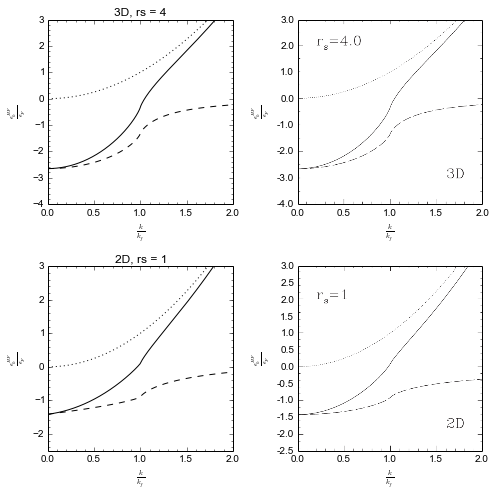

In [3]:
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
fig, axes = plt.subplots(2,2,figsize=(7,7))

#3D plot
run.ndim = 3
run.rs = 4.0
run.kf = (9 * np.pi / 4)**(1./3.) * (1 / run.rs) 
fermi_energy = 0.5 * run.kf**2
x = np.linspace(0, 2.0 * run.kf, 500)
energy_x = np.array([energy(i) for i in x]) / fermi_energy
kinetic_x = np.array([0.5 * i**2 for i in x]) / fermi_energy
exch_x = np.array([exch(i) for i in x]) / fermi_energy
x = x / run.kf  #rescale for plot
axes[0,0].plot(x, energy_x, 'k-' , label='total energy')
axes[0,0].plot(x, kinetic_x, 'k:', label='kinetic energy')
axes[0,0].plot(x, exch_x, 'k--', label='exchange energy')
axes[0,0].set_title('3D, rs = 4')
axes[0,0].set_xlabel(r'$\frac{k}{k_f}$')
axes[0,0].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')
axes[0,0].set_xlim(0,2)
axes[0,0].set_ylim(-4.0,3.0)

#add minor ticks
minor_locator = AutoMinorLocator(5)
axes[0,0].yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
minor_locator = AutoMinorLocator(5)
axes[0,0].xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#2D plot
run.ndim = 2
run.rs = 1.0
run.kf = 2**0.5 / run.rs
fermi_energy = 0.5 * run.kf**2
x = np.linspace(0, 2.0 * run.kf, 500)
energy_x = np.array([energy(i) for i in x]) / fermi_energy
kinetic_x = np.array([0.5 * i**2 for i in x]) / fermi_energy
exch_x = np.array([exch(i) for i in x]) / fermi_energy
x = x / run.kf  #rescale for plot

axes[1,0].plot(x, energy_x, 'k-' , label='total energy')
axes[1,0].plot(x, kinetic_x, 'k:', label='kinetic energy')
axes[1,0].plot(x, exch_x, 'k--', label='exchange energy')
axes[1,0].set_title('2D, rs = 1')
axes[1,0].set_xlabel(r'$\frac{k}{k_f}$')
axes[1,0].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')
axes[1,0].set_xlim(0,2)
axes[1,0].set_ylim(-2.5,3)

#add minor ticks
minor_locator = AutoMinorLocator(5)
axes[1,0].yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')
minor_locator = AutoMinorLocator(5)
axes[1,0].xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor')

#3D Figure
image = mpimg.imread("HF_singleparticleenergy_3D_Guiliani2005_fig2.1_cropped.png")
ntix = 5
xlabels = np.linspace(0,2,ntix)
xtix = np.linspace(0, image.shape[0], ntix)
ntix = 8
ytix = np.linspace(0, image.shape[1], ntix)
ylabels = np.linspace(-4,3,ntix)
axes[0,1].axis('on')
axes[0,1].imshow(image[::-1,:,:])
axes[0,1].set_xticks(xtix,minor=False)
axes[0,1].set_xticklabels(xlabels)
axes[0,1].set_xlim(0,image.shape[0])
axes[0,1].set_yticks(ytix)
axes[0,1].set_yticklabels(ylabels)
axes[0,1].set_ylim(0,image.shape[1])
axes[0,1].tick_params(top='off', bottom='off', left='off', right='off')
axes[0,1].set_xlabel(r'$\frac{k}{k_f}$')
axes[0,1].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')


#2D Figure
image = mpimg.imread("HF_singleparticleenergy_2D_Guiliani2005_fig2.2_cropped.png")
ntix = 5
xlabels = np.linspace(0,2,ntix)
xtix = np.linspace(0, image.shape[0], ntix)
ntix = 12
ytix = np.linspace(0, image.shape[1], ntix)
ylabels = np.linspace(-2.5,3,ntix)
axes[1,1].axis('on')
axes[1,1].imshow(image[::-1,:,:])
axes[1,1].set_xticks(xtix,minor=False)
axes[1,1].set_xticklabels(xlabels)
axes[1,1].set_xlim(0,image.shape[0])
axes[1,1].set_yticks(ytix)
axes[1,1].set_yticklabels(ylabels)
axes[1,1].set_ylim(0,image.shape[1])
axes[1,1].tick_params(top='off', bottom='off', left='off', right='off')
axes[1,1].set_xlabel(r'$\frac{k}{k_f}$')
axes[1,1].set_ylabel(r'$\frac{\epsilon_k^{HF}}{\epsilon_F}$')

plt.tight_layout()
plt.show()